In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337

set_seed(seed)

In [3]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [4]:
from dotenv import load_dotenv

load_dotenv()

from service import EnvironmentSecretService

In [5]:
from core.models.exchange import ExchangeType
from core.models.lookback import Lookback
from core.models.timeframe import Timeframe
from exchange import ExchangeFactory

In [6]:
DEFAULT_EXCHANGE = ExchangeType.BYBIT
DEFAULT_TIMEFRAME = Timeframe.FIFTEEN_MINUTES
DEFAULT_LOOKBACK = Lookback.EIGHT_MONTH

from datetime import datetime

today = datetime.now().strftime('%Y-%m-%d')

raw_df_filename = f'ocean_raw_{DEFAULT_TIMEFRAME}_{DEFAULT_LOOKBACK}_{today}.csv'
features_filename = f'ocean_features_{today}.npy'
symbol_indices_filename = f'ocean_symbol_idx_{today}.npy'
emb_filename = f'ocean_emb_{today}.npy'
volume_df_filename = f'ocean_vol_{today}.csv'
res_filename = f'ocean_res_{today}.npy'

In [7]:
exchange_factory = ExchangeFactory(EnvironmentSecretService())
exchange = exchange_factory.create(DEFAULT_EXCHANGE)

In [ ]:
symbols = exchange.fetch_future_symbols()

data = []
for symbol in symbols:
    try:
        for ohlcv in exchange.fetch_ohlcv(symbol, DEFAULT_TIMEFRAME, DEFAULT_LOOKBACK):
            _timestamp, _open, _high, _low, _close, _volume = ohlcv
            data.append([symbol.name, _timestamp, _open, _high, _low, _close, _volume])
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")

symbols_df = pd.DataFrame(data, columns=['Symbol', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')
symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'], unit='ms')

symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [ ]:
symbols_df.to_csv(raw_df_filename, index=False)

In [ ]:
symbols_df = pd.read_csv(raw_df_filename)
float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')

symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'])
symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [ ]:
symbols_df.head()

In [ ]:
def volume_features(df, period_14=14, period_20=20):
    df = df.copy()

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    df['Date'] = df['Timestamp'].dt.date
    df['Previous Close'] = df.groupby('Symbol')['Close'].shift(1)

    df['Typical Price'] = (df['High'] + df['Low'] + df['Close']) / 3

    grouped = df.groupby(['Symbol', 'Date'])

    df['ADV'] = grouped['Volume'].transform('mean')
    df['Cumulative Price * Volume'] = df['Typical Price'] * df['Volume']
    df['Cum_Volume'] = grouped['Volume'].cumsum()
    df['Cum_Price_Volume'] = grouped['Cumulative Price * Volume'].cumsum()
    df['VWAP'] = df['Cum_Price_Volume'] / df['Cum_Volume'].replace(0, 1e-6)
    df['VWAP_MOM'] = df.groupby('Symbol')['VWAP'].diff()

    df['Midpoint Move'] = (df['High'] + df['Low']) / 2 - (df['High'].shift(1) + df['Low'].shift(1)) / 2
    df['Box Ratio'] = (df['Volume'] / 1e6) / (df['High'] - df['Low']).replace(0, 1e-6)
    df['EOM'] = df['Midpoint Move'] / df['Box Ratio']
    df['EOM'] = df.groupby('Symbol')['EOM'].transform(lambda x: x.rolling(window=period_14).mean())

    df['Price Change'] = grouped['Close'].diff()
    df['OBV'] = (np.sign(df['Price Change']) * df['Volume']).groupby(df['Symbol']).cumsum()

    df['A/D'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / ((df['High'] - df['Low']) * df['Volume']).replace(0, 1e-6)
    df['A/D'] = grouped['A/D'].cumsum()

    df['CMF'] = df['A/D'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).sum())

    df['Amihud_Illiquidity'] = df['Price Change'].abs() / df['Volume']
    df['Amihud_Illiquidity'] = grouped['Amihud_Illiquidity'].transform('mean')

    df['Liquidity_Ratio'] = df['Volume'] / df['Typical Price'].replace(0, 1e-6)

    df['II'] = (2 * df['Close'] - df['High'] - df['Low']) / ((df['High'] - df['Low']) * df['Volume']).replace(0, 1e-6)

    df['Raw Money Flow'] = df['Typical Price'] * df['Volume']
    df['Positive Money Flow'] = df['Raw Money Flow'].where(df['Price Change'] > 0, 0)
    df['Negative Money Flow'] = df['Raw Money Flow'].where(df['Price Change'] < 0, 0)

    df['Positive Money Flow Sum'] = df.groupby('Symbol')['Positive Money Flow'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Negative Money Flow Sum'] = df.groupby('Symbol')['Negative Money Flow'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Money Flow Ratio'] = df['Positive Money Flow Sum'] / df['Negative Money Flow Sum'].replace(0, 1e-6)
    df['MFI'] = 100 - (100 / (1 + df['Money Flow Ratio']))

    df['True Range'] = df[['High', 'Low', 'Previous Close']].apply(lambda x: max(x[0] - x[1], abs(x[0] - x[2]), abs(x[1] - x[2])), axis=1)
    df['LII'] = df['Volume'] / (df['Typical Price'] * df['True Range']).replace(0, 1e-6)

    df['Buy Volume'] = df['Volume'].where(df['Price Change'] > 0, 0)
    df['Sell Volume'] = df['Volume'].where(df['Price Change'] < 0, 0)

    df['Volume IMB'] = df.groupby('Symbol')['Buy Volume'].transform(lambda x: x.rolling(window=period_20).sum()) - df.groupby('Symbol')['Sell Volume'].transform(lambda x: x.rolling(window=period_20).sum())
    df['Flow_R'] = df['Buy Volume'] / df['Sell Volume'].replace(0, 1e-6)

    df['CVD'] = df['Buy Volume'] - df['Sell Volume']
    df['CVD'] = df.groupby('Symbol')['CVD'].cumsum()

    df['RVOL'] = df['Volume'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).mean()).replace(0, 1e-6)

    df['KVO'] = (df['Volume'] * (2 * (df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])).ewm(span=period_14, adjust=False).mean()

    df['VROC'] = df['Volume'].pct_change(period_14)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    drop_columns = [
        'Date', 'Typical Price', 'Cum_Volume', 'Cum_Price_Volume', 'Cumulative Price * Volume',
        'Buy Volume', 'Sell Volume', 'Midpoint Move', 'Price Change', 'Positive Money Flow',
        'Negative Money Flow', 'Previous Close', 'Raw Money Flow'
    ]
    df.drop(columns=drop_columns, inplace=True)

    return df

In [ ]:
volume_df = volume_features(symbols_df)
volume_df.to_csv(volume_df_filename, index=False)

In [8]:
volume_df = pd.read_csv(volume_df_filename)

In [9]:
volume_df.shape[0]

8034150

In [10]:
volume_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume,ADV,VWAP,VWAP_MOM,...,II,MFI,LII,HL,Volume_IMB,Flow_R,CVD,RVOL,KVO,VROC
0,10000000AIDOGEUSDT,2024-03-05 10:45:00,0.004816,0.004816,0.004807,0.004807,400.0,213498380.0,0.004810,NaN,...,-2.500000e-03,NaN,9.240178e+09,0.000009,NaN,0.0000,0.0,NaN,-4.000000e+02,NaN
1,10000000AIDOGEUSDT,2024-03-05 11:00:00,0.004807,0.006305,0.004617,0.006210,719649400.0,213498380.0,0.005711,0.000901,...,1.233157e-09,NaN,7.465549e+13,0.001688,NaN,719.6494,719649400.0,NaN,1.757055e+08,NaN
2,10000000AIDOGEUSDT,2024-03-05 11:15:00,0.006210,0.007224,0.005910,0.006182,743186300.0,213498380.0,0.006081,0.000370,...,-7.884923e-10,NaN,8.784284e+13,0.001314,NaN,0.0000,-23536896.0,NaN,1.147229e+08,NaN
3,10000000AIDOGEUSDT,2024-03-05 11:30:00,0.006182,0.006208,0.005710,0.005939,321725900.0,213498380.0,0.006057,-0.000023,...,-2.496596e-10,NaN,1.085350e+14,0.000498,NaN,0.0000,-345262800.0,NaN,1.157066e+08,NaN
4,10000000AIDOGEUSDT,2024-03-05 11:45:00,0.005939,0.006073,0.005634,0.005765,209583600.0,213498380.0,0.006033,-0.000025,...,-1.923765e-09,NaN,8.197313e+13,0.000439,NaN,0.0000,-554846400.0,NaN,9.735090e+07,NaN


In [11]:
symbols = volume_df['Symbol'].unique()
n_symbols = len(symbols)

print("N Symbols: ", n_symbols)

N Symbols:  411


In [12]:
volume = ['ADV', 'RVOL', 'Volume_IMB', 'CVD', 'VROC']
price_volume = ['VWAP', 'VWAP_MOM', 'MFI', 'Flow_R', 'KVO', 'EOM']
liquidity = ['Amihud_Illiquidity', 'LII', 'HL', 'II']
accumulation_distribution = ['A/D', 'OBV', 'CMF']

features = volume + price_volume + liquidity + accumulation_distribution
n_features = len(features)

print("N Features: ", n_features)

N Features:  18


In [13]:
segment_length = 512
overlap = 128

print("NaN values before imputation:\n", volume_df.isna().sum())
imputer = SimpleImputer(strategy='constant', fill_value=0.0)
volume_df[features] = imputer.fit_transform(volume_df[features])

symbol_sequences = [volume_df[volume_df['Symbol'] == symbol][features].to_numpy() for symbol in symbols]
print("Symbol seq: ", len(symbol_sequences))

def segment_sequence(sequence, segment_length, overlap, pad_left=False):
    segments = []
    step = segment_length - overlap

    for start in range(0, len(sequence), step):
        end = min(start + segment_length, len(sequence))
        segment = sequence[start:end]

        if len(segment) < segment_length:
            pad_width = segment_length - len(segment)

            if pad_left:
                segment = np.pad(segment, ((pad_width, 0), (0, 0)), 'constant')
            else:
                segment = np.pad(segment, ((0, pad_width), (0, 0)), 'constant')

        segments.append(segment)

    return segments

def segment_all_sequences(sequences, segment_length, overlap):
    segmented_sequences = []
    segment_symbol_indices = []
    for symbol_idx, seq in enumerate(sequences):
        segments = segment_sequence(seq, segment_length, overlap)
        segmented_sequences.extend(segments)
        segment_symbol_indices.extend([symbol_idx] * len(segments))
    return segmented_sequences, segment_symbol_indices

segmented_sequences, segment_symbol_indices = segment_all_sequences(symbol_sequences, segment_length=segment_length, overlap=overlap)
segmented_sequences = np.array(segmented_sequences)

n_segments, segment_length, n_features = segmented_sequences.shape

scaler = StandardScaler()
segmented_sequences = segmented_sequences.reshape(-1, n_features)
normalized_segments = scaler.fit_transform(segmented_sequences)
normalized_segments = normalized_segments.reshape(n_segments, segment_length, n_features)

print("Shape of normalized features:", normalized_segments.shape)
print("Number of symbols:", n_symbols)

np.save(features_filename, normalized_segments)
np.save(symbol_indices_filename, segment_symbol_indices)


NaN values before imputation:
 Symbol                    0
Timestamp                 0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
ADV                       0
VWAP                      0
VWAP_MOM                411
EOM                   75199
OBV                       0
A/D                       0
CMF                    5363
Amihud_Illiquidity        0
Liquidity_Ratio           0
II                        0
MFI                    5343
LII                       0
HL                        0
Volume_IMB             7809
Flow_R                    0
CVD                       0
RVOL                   7809
KVO                       0
VROC                   9955
dtype: int64
Symbol seq:  411
Shape of normalized features: (20992, 512, 18)
Number of symbols: 411


In [22]:
from notebooks.pipelines import ocean_train

epochs = 40
latent_dim = 32
lr = 1e-9

ocean_train.run_training(
    features_filename=features_filename,
    emb_filename=emb_filename,
    epochs=epochs,
    latent_dim=latent_dim,
    lr=lr,
)

RANK: 0, WORLD_SIZE: 1
Loaded snapshot: snapshots/AutoEncoder_epoch_11_improved.pth
Start training with epochs 40
Epoch [1/40], Train Loss: 1.23892597
Saved improved snapshot: snapshots/AutoEncoder_epoch_1_improved.pth
Removed excess snapshot: snapshots/AutoEncoder_epoch_11_improved.pth
Epoch [2/40], Train Loss: 1.23882238
Saved improved snapshot: snapshots/AutoEncoder_epoch_2_improved.pth
Removed excess snapshot: snapshots/AutoEncoder_epoch_22_periodic.pth
Epoch [3/40], Train Loss: 1.23889279
Saved periodic snapshot: snapshots/AutoEncoder_epoch_3_periodic.pth
Removed excess snapshot: snapshots/AutoEncoder_epoch_23_periodic.pth
Epoch [4/40], Train Loss: 1.23892990
Saved periodic snapshot: snapshots/AutoEncoder_epoch_4_periodic.pth
Removed excess snapshot: snapshots/AutoEncoder_epoch_1_improved.pth
Epoch [5/40], Train Loss: 1.23892378
Saved periodic snapshot: snapshots/AutoEncoder_epoch_5_periodic.pth
Removed old periodic snapshot: snapshots/AutoEncoder_epoch_3_periodic.pth
Removed old 

In [14]:
embeddings = np.load(emb_filename)
segment_symbol_indices = np.load(symbol_indices_filename)

print("Embedding shape:", embeddings.shape)
print("Symbol Idx shape:", segment_symbol_indices.shape)

symbol_embeddings_dict = {symbol: [] for symbol in symbols}

for i, symbol_idx in enumerate(segment_symbol_indices):
    symbol = symbols[symbol_idx]
    symbol_embeddings_dict[symbol].append(embeddings[i])

res_df = pd.DataFrame({
    'symbol': symbol_embeddings_dict.keys(),
    'embeddings': symbol_embeddings_dict.values()
})

print("DF shape:", res_df.shape)
print("\n", res_df.head())

Embedding shape: (20992, 32)
Symbol Idx shape: (20992,)
DF shape: (411, 2)

                 symbol                                         embeddings
0   10000000AIDOGEUSDT  [[0.011760788, -0.09532021, 0.1070695, -0.1998...
1  1000000BABYDOGEUSDT  [[0.07101434, -0.068117194, 0.21286118, -0.261...
2       1000000MOGUSDT  [[-0.03998029, -0.00088632706, 0.24008411, -0....
3    1000000PEIPEIUSDT  [[0.06562033, -0.08800517, 0.134178, -0.237051...
4         10000COQUSDT  [[0.06830923, -0.108638674, 0.12064325, -0.181...


In [15]:
all_embeddings = np.vstack(res_df['embeddings'].values)
all_embeddings.shape

(20992, 32)

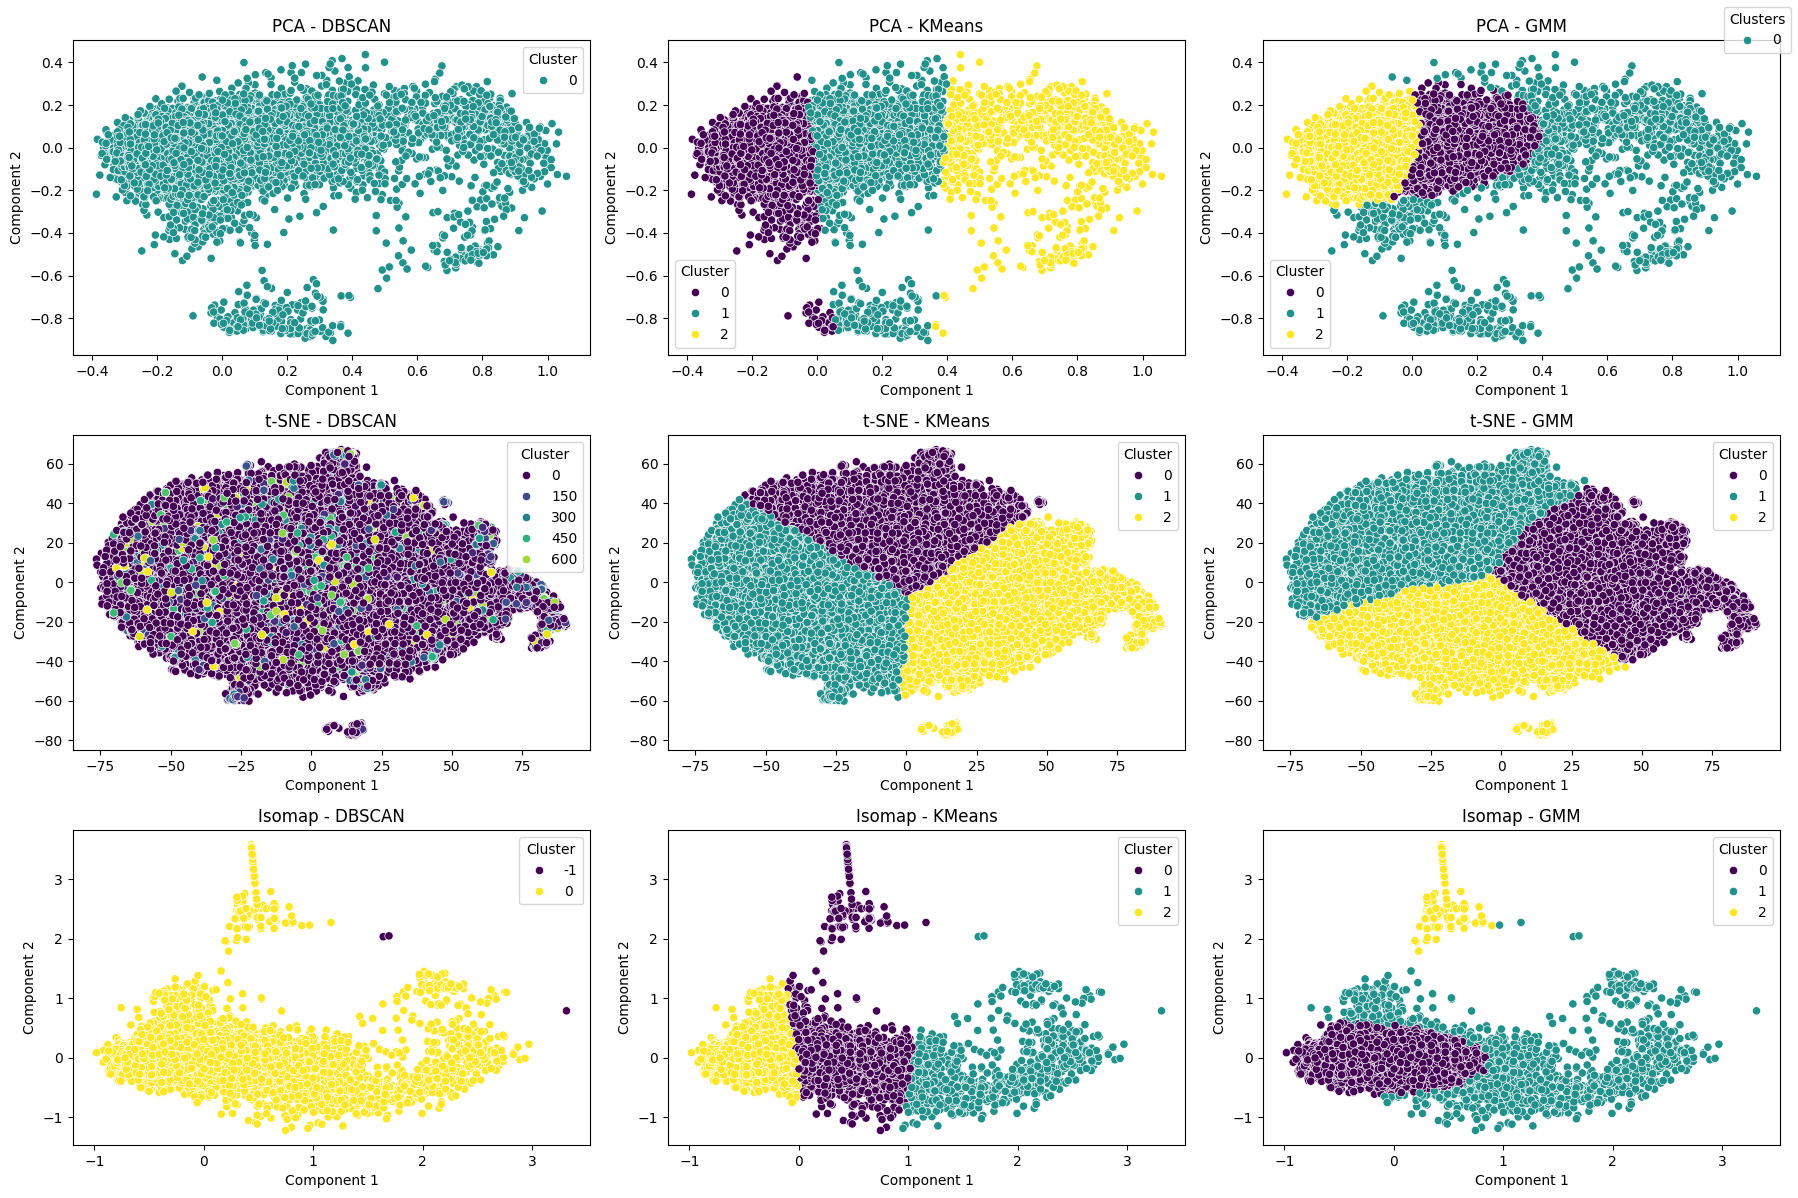

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.mixture import GaussianMixture

n_clusters = 3
n_components = 2

def visualize_clustering(all_embeddings, n_clusters=3, n_components=2, random_state=1337):
    clustering_methods = {
        "DBSCAN": DBSCAN(),
        "KMeans": KMeans(n_clusters=n_clusters),
        "GMM": GaussianMixture(n_components=n_clusters),
    }

    dimensionality_methods = {
        "PCA": PCA(n_components=n_components, random_state=random_state),
        "t-SNE": TSNE(n_components=n_components, random_state=random_state),
        "Isomap": Isomap(n_components=n_components),
        # "MDS": MDS(n_components=n_components),
        # "Factor Analysis": FactorAnalysis(n_components=n_components),
    }

    fig, axes = plt.subplots(len(dimensionality_methods), len(clustering_methods), figsize=(18, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, (dim_name, dim_method) in enumerate(dimensionality_methods.items()):
        reduced_embeddings = dim_method.fit_transform(all_embeddings)

        for j, (cluster_name, cluster_method) in enumerate(clustering_methods.items()):
            cluster_labels = cluster_method.fit_predict(reduced_embeddings)

            df = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])
            df['Cluster'] = cluster_labels

            sns.scatterplot(data=df, x='Component 1', y='Component 2', hue='Cluster', palette='viridis', ax=axes[i, j], legend='auto')
            axes[i, j].set_title(f'{dim_name} - {cluster_name}')
            axes[i, j].set_xlabel('Component 1')
            axes[i, j].set_ylabel('Component 2')

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Clusters', loc='upper right')

    plt.tight_layout()
    plt.show()

visualize_clustering(all_embeddings, n_clusters=n_clusters, n_components=n_components, random_state=seed)

In [19]:

def adjust_embedding_length(emb, target_length):
    emb = np.array(emb)

    if len(emb) < target_length:
        pad_width = target_length - len(emb)
        return np.pad(emb, (0, pad_width), 'constant')

    return emb[:target_length]

def flat_embeddings(df):
    df = df.copy()

    df['flat_embeddings'] = df['embeddings'].apply(lambda emb: [val for sublist in emb for val in sublist])

    embedding_lengths = df['flat_embeddings'].apply(len)
    max_length = embedding_lengths.max() if not embedding_lengths.empty else 0

    df['flat_embeddings'] = df['flat_embeddings'].apply(lambda emb: adjust_embedding_length(emb, max_length))

    return df

def reduce_embeddings(df, n_reduced=10):
    df = df.copy()

    flat_embeddings = np.array(df['flat_embeddings'].tolist())

    pca = PCA(n_components=n_reduced)
    reduced_embeddings = pca.fit_transform(flat_embeddings)

    df['reduced_embeddings'] = list(reduced_embeddings)

    reduced_lengths = df['reduced_embeddings'].apply(len)
    reduced_uniq_lengths = reduced_lengths.value_counts()

    print("Reduced embedding lengths and counts:")
    print(reduced_uniq_lengths)

    return df

def optimal_n_components(df, threshold=0.90):
    flat_embeddings = np.array(df['flat_embeddings'].tolist())

    pca = PCA()
    pca.fit(flat_embeddings)

    cumulative_variance = pca.explained_variance_ratio_.cumsum()

    n_components = np.argmax(cumulative_variance >= threshold) + 1
    return n_components

flat_emb_df = flat_embeddings(res_df)
n_reduced = optimal_n_components(flat_emb_df)
print(f"n_components: {n_reduced}")

reduce_emb_df = reduce_embeddings(flat_emb_df, n_reduced=n_reduced)

simularity_values = reduce_emb_df[['symbol', 'reduced_embeddings']].values
print('\n', simularity_values[0])

np.save(f"out/{res_filename}", simularity_values)

n_components: 182
Reduced embedding lengths and counts:
reduced_embeddings
182    411
Name: count, dtype: int64

 ['10000000AIDOGEUSDT'
 array([-1.08852185e-01, -7.16628551e-01,  1.43751693e+00, -5.97607732e-01,
         8.14742327e-01, -1.77018091e-01, -4.93758202e-01,  5.99305481e-02,
        -1.73716336e-01, -7.65209422e-02, -1.11507408e-01, -9.13715884e-02,
         7.36895263e-01,  1.89707190e-01,  1.95674170e-02,  2.40630761e-01,
         1.12279274e-01, -1.65019646e-01,  2.23231867e-01,  3.59411389e-01,
        -1.43173616e-02, -9.41486061e-02, -2.11281732e-01,  6.71781361e-01,
         3.58178943e-01,  4.94882166e-01,  9.21058357e-02,  5.41462421e-01,
        -4.68110889e-01, -3.78577001e-02,  3.26009393e-01,  2.95113206e-01,
        -3.24851483e-01,  4.95897204e-01,  3.90486903e-02,  7.33616017e-03,
        -1.49793759e-01, -1.44267306e-01,  6.64613619e-02,  3.31064999e-01,
         1.46903664e-01, -1.39504075e-01,  2.20316323e-03, -1.99957162e-01,
        -6.43053129e-02,  2.

In [21]:
from ocean import SIM

max_level = 8
max_neighbors = 40
ef_construction = 500
ef_search = 50

gsim = SIM(
    max_level=max_level,
    max_neighbors=max_neighbors,
    ef_construction=ef_construction,
    ef_search=ef_search
)

embs = np.load(f"out/{res_filename}", allow_pickle=True)

for symbol, emb in embs:
    gsim.insert(emb, symbol)

In [22]:
from core.models.cap import CapType

symbol = 'SOLUSDT'
val = reduce_emb_df[reduce_emb_df['symbol'] == symbol]['reduced_embeddings'].values
query = val[0]

print(f"Symbol: {symbol}")

neighbors = gsim.search(query, 8)
n_neighbors = len(neighbors)

print(f"Found {n_neighbors} nearest neighbors for the query.")

for i, neighbors in enumerate(neighbors):
    dist, node = neighbors
    print(f"{i} neighbor Symbol: {node.meta['symbol']}")

simular_symbols = gsim.find_similar_symbols(symbol, 4)
n_symbols = len(simular_symbols)

print(f"Found {n_symbols} simular symbols")

for symbol in simular_symbols:
    print(f"Symbol: {symbol}")

cap = CapType.A
cap_symbols = gsim.find_similar_by_cap(cap, top_k=18)
n_symbols = len(cap_symbols)

print(f"Found {n_symbols} symbols by: {cap.name}")

for symbol in cap_symbols:
    print(f"Symbol: {symbol}")

Symbol: SOLUSDT
Found 8 nearest neighbors for the query.
0 neighbor Symbol: THETAUSDT
1 neighbor Symbol: BIGTIMEUSDT
2 neighbor Symbol: STRKUSDT
3 neighbor Symbol: 10000000AIDOGEUSDT
4 neighbor Symbol: ZBCNUSDT
5 neighbor Symbol: REZUSDT
6 neighbor Symbol: SPECUSDT
7 neighbor Symbol: PIRATEUSDT
Found 5 simular symbols
Symbol: THETAUSDT
Symbol: BIGTIMEUSDT
Symbol: STRKUSDT
Symbol: 10000000AIDOGEUSDT
Symbol: ZBCNUSDT
Found 9 symbols by: A
Symbol: THETAUSDT
Symbol: BIGTIMEUSDT
Symbol: STRKUSDT
Symbol: 10000000AIDOGEUSDT
Symbol: ZBCNUSDT
Symbol: REZUSDT
Symbol: SPECUSDT
Symbol: PIRATEUSDT
Symbol: MAXUSDT
